In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set_style('whitegrid')

In [3]:
oxy = pd.read_csv('oxy_intake.csv', delim_whitespace=' ')

In [4]:
oxy

,uptake,intercept,aerobic,age,aerobic.age
0,-0.87,1.0,0.0,23.0,0.0
1,-10.74,1.0,0.0,22.0,0.0
2,-3.27,1.0,0.0,22.0,0.0
3,-1.97,1.0,0.0,25.0,0.0
4,7.50,1.0,0.0,27.0,0.0
5,-7.25,1.0,0.0,20.0,0.0
6,17.05,1.0,1.0,31.0,31.0
7,4.96,1.0,1.0,23.0,23.0
8,10.40,1.0,1.0,27.0,27.0
9,11.05,1.0,1.0,28.0,28.0


<AxesSubplot:xlabel='age', ylabel='uptake'>

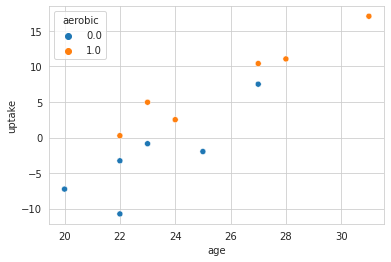

In [5]:
sns.scatterplot(data=oxy, hue='aerobic', x='age', y='uptake')

In [7]:
feature_cols = ['intercept', 'aerobic', 'age', 'aerobic.age']
X = oxy[feature_cols]
y = oxy['uptake']

In [410]:
with pm.Model() as model:
    X_tt = pm.Data("X", X)

    z = pm.Bernoulli('Z', p=0.5, shape=(X.shape[1], ))

    # zellner g-prior with unit information g = n
    τ = pm.Gamma("τ", alpha=1/2, beta=(1*8.54)/2)
    β = pm.MvNormal("β", mu=np.zeros(4), cov=1/τ * X.shape[0] * np.linalg.inv(X.T@X), shape=(X.shape[1],))
    
    zβ = pm.Deterministic('zβ', pm.math.prod([z, β], axis=0))
    likelihood = pm.Normal("y", mu=pm.math.dot(X, zβ), tau=τ, observed=y)

In [411]:
with model:
    post_ss = pm.sample(3000, tune=2000, chains=4, progressbar=True, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [Z]
>NUTS: [β, τ]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 52 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3401773414570476, but should be close to 0.8. Try to increase the number of tuning steps.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
There were 397 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.682174111306163, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'Z'}>,
        <AxesSubplot:title={'center':'Z'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'τ'}>,
        <AxesSubplot:title={'center':'τ'}>],
       [<AxesSubplot:title={'center':'zβ'}>,
        <AxesSubplot:title={'center':'zβ'}>]], dtype=object)

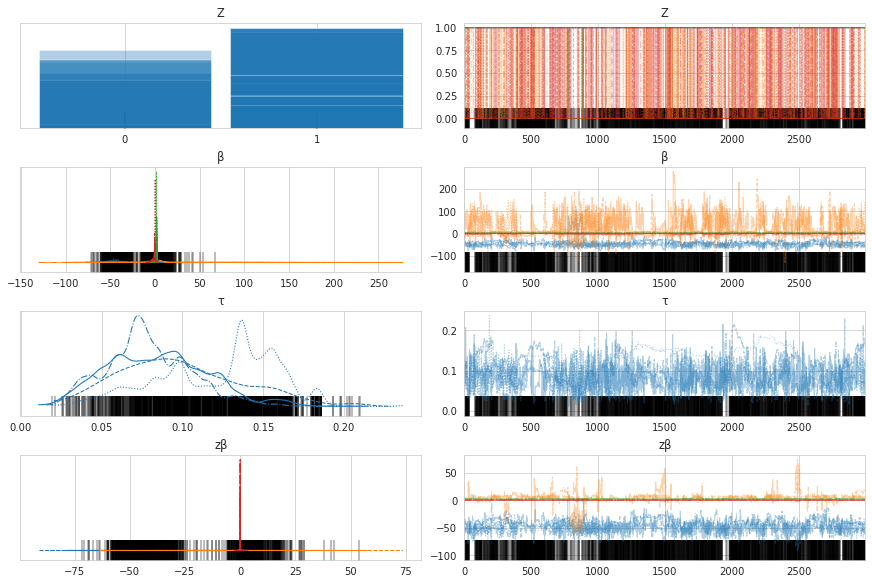

In [412]:
az.plot_trace(post_ss)

In [453]:
(post_ss['posterior']['zβ'][1].to_numpy()).mean(0)

array([-47.39759796,   1.3812013 ,   1.95897561,   0.08996806])

<AxesSubplot:xlabel='level_1', ylabel='0'>

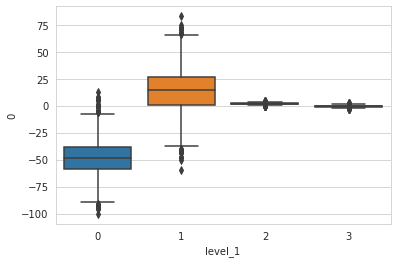

In [298]:
sns.boxplot(data=pd.DataFrame(post_ss['posterior']['β'][1].to_numpy()).stack().reset_index(), y=0, x='level_1')

<AxesSubplot:xlabel='level_1', ylabel='0'>

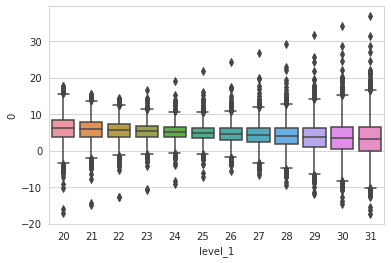

In [300]:
b = post_ss['posterior']['β'][0].to_numpy()

effect = {}
for age in range(20, 32):
    effect[age] = b[:,1] + b[:,3]*age

sns.boxplot(data=pd.DataFrame(effect).stack().reset_index(1), y=0, x='level_1')

In [414]:
pp = pm.sample_posterior_predictive(post_ss, samples=5000, model=model, var_names=['zβ', 'y'])

<AxesSubplot:xlabel='level_1', ylabel='0'>

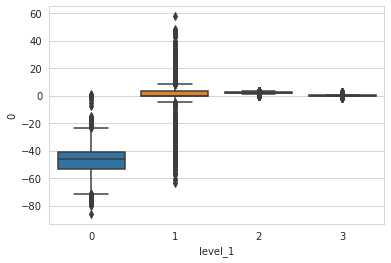

In [418]:
sns.boxplot(data=pd.DataFrame(pp['zβ']).stack().reset_index(), y=0, x='level_1')

<AxesSubplot:xlabel='level_1', ylabel='0'>

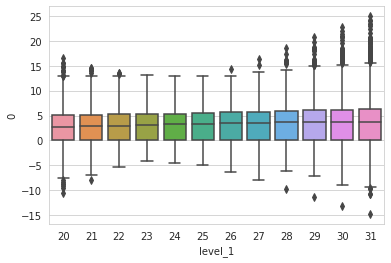

In [425]:
b = pp['zβ']

effect = {}
for age in range(20, 32):
    effect[age] = b[:,1] + b[:,3]*age

sns.boxplot(data=pd.DataFrame(effect).stack().reset_index(1), y=0, x='level_1')

In [439]:
pp = pm.sample_posterior_predictive(post_ss, samples=5000, model=model, var_names=['Z'])

/home/ztang484/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [442]:
pp['Z'].mean(0)

array([0.9776, 0.3676, 0.9778, 0.4204])